In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding as LLE, SpectralEmbedding as SpectEmbed
import jax
import jax.numpy as jnp
import equinox as eqx
import os
import sklearn.manifold as manifold

In [133]:
class autoencoder_encode(eqx.Module):
    layers: list

    def __init__(self, *, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.layers = [
            eqx.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, key=key1),
            # jax.nn.relu,
            jax.nn.leaky_relu,
            eqx.nn.MaxPool2d((2, 2), 2),
            eqx.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, key=key2),
            # jax.nn.relu,
            jax.nn.leaky_relu,
            eqx.nn.MaxPool2d((2, 2), 2),
            eqx.nn.Lambda(lambda z: z.reshape(*z.shape[:-3], -1)),
            # eqx.nn.Lambda(lambda z:jnp.moveaxis(z,0,-1)),
            eqx.nn.Linear(1568, 128, key=key3),
            jax.nn.leaky_relu,
            # jax.nn.relu,
            eqx.nn.Linear(128,1568,key=key4),
            jax.nn.leaky_relu,
            # jax.nn.relu,
            eqx.nn.Lambda(lambda z: z.reshape(*z.shape[:-1],32,7,7))
            # eqx.nn.Lambda(lambda z:jnp.moveaxis(z,-1,0))
        ]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)
        return x

# ============================================================================ #
# Decode
class autoencoder_decode(eqx.Module):
    layers: list
    
    def __init__(self, *, key):
        _, _, _, _, key5, key6, key7 = jax.random.split(key,7)
        self.layers = [
            eqx.nn.ConvTranspose(2, in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0, key=key5),
            jax.nn.relu,
            eqx.nn.ConvTranspose(2, in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0, key=key6),
            jax.nn.relu,
            eqx.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1, key=key7),
            # jax.nn.sigmoid
        ]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# ============================================================================ #
# Combined
class autoencoder(eqx.Module):
    modules: list
    def __init__(self, *, key):
        encoder = autoencoder_encode(key=key)
        decoder = autoencoder_decode(key=key)
        self.modules = [encoder, decoder]
    def __call__(self, x):
        for layer in self.modules:
            x = layer(x)
        return x
primary_key=jax.random.PRNGKey(0)
model_key,noise_key1,noise_key2,display_key=jax.random.split(primary_key,4)
model=autoencoder(key=model_key)
base_model=autoencoder(key=model_key)
mnist_model = eqx.tree_deserialise_leaves("/fred/oz440/jonah/module_equinox_cae/results/trained_models/trained_modelsmnist_noisy.eqx",base_model)
emnist_model=eqx.tree_deserialise_leaves("/fred/oz440/jonah/module_equinox_cae/results/trained_models/emnist_noisy.eqx",base_model)


def load_train_val(path: str):
    ext=os.path.splitext(path)[1].lower()
    if ext!=".npz":
        raise ValueError(f"Unsupported file extension: {ext}. Only .npz files are supported.")
    data=jnp.load(path)
    keys=list(data.keys())
    if "x_train" in keys and "x_test" in keys:
        x_train=data["x_train"]
        x_test=data["x_test"]
    else:
        if len(keys)<2:
            raise ValueError(f"Not enough arrays in .npz file. Found keys: {keys}")
        else:
            raise ValueError(f"Could not find 'x_train' and 'x_test' in .npz file. Found keys: {keys}")
    
    return x_train, x_test

def preprocess(array: jnp.ndarray):
    array=array.astype("float32")/255.0
    array=jnp.resize(jnp.array(array),(len(array),1,28,28,))
    return array

def noise(array,noise_factor,key):
    normal_key,uniform_key=jax.random.split(key,2)
    if noise_factor==None:
        noise_factor=jax.random.uniform(uniform_key,shape=(array.shape[0],1,1,1),minval=0.0,maxval=1.0)
    noisy_array=array+noise_factor*jax.random.normal(normal_key,array.shape)
    return jnp.clip(noisy_array,0.,1.)

def runModel(data,model):
    return jax.nn.sigmoid(jax.vmap(model)(data))

def runEmbeddings(data,model):
    return jax.vmap(model.modules[0])(data)

def plot_embeddings(non_noisy,noisy,embeds,key,model_name,n=10):
    idx=jax.random.randint(key,(10,),0,len(non_noisy))
    non_noisy_imgs=non_noisy[idx,:]
    noisy_imgs=noisy[idx,:]
    embed_imgs=embeds[idx,:]

    fig,axes=plt.subplots(10,34,figsize=(68,20))
    plt.suptitle(f"Embeddings from {model_name} model")

    for i in range(10):
        axes[i,0].imshow(non_noisy_imgs[i,0,:],cmap="plasma")
        axes[i,0].axis("off")
        axes[i,1].imshow(noisy_imgs[i,0,:],cmap="plasma")
        axes[i,1].axis("off")

        for j in range(32):
            axes[i,j+2].imshow(embed_imgs[i,j],cmap="plasma")
            axes[i,j+2].axis("off")
    plt.tight_layout()
    plt.show()



def plot_preds(non_noisy, noisy, predictions, key,model_name, n=10):
    """
    Saves ten random image from each one of the supplied arrays
    """
    idx=jax.random.randint(key, (10,),0,len(non_noisy))
    non_noisy_imgs=non_noisy[idx,:]
    noisy_imgs=noisy[idx,:]
    pred_imgs=predictions[idx,:]

    fig=plt.figure(figsize=(20,6),layout="tight")
    plt.suptitle(f"Results from {model_name} model", fontsize=16)

    for i, (non_noisy_img, noisy_img, pred_img) in enumerate(zip(non_noisy_imgs,noisy_imgs,pred_imgs)):
        ax=plt.subplot(3,n,i+1)
        plt.imshow(non_noisy_img.reshape(28,28))
        plt.plasma()
        ax.set_axis_off()
        if i==0:
            ax.set_title("Target Data",loc="left",fontsize=10)
        
        ax=plt.subplot(3,n,i+1+n)
        plt.imshow(noisy_img.reshape(28,28))
        plt.plasma()
        ax.set_axis_off()
        if i==0:
            ax.set_title("Input Data",loc="left",fontsize=10)
        
        ax=plt.subplot(3,n,i+1+2*n)
        plt.imshow(pred_img.reshape(28,28))
        plt.plasma()
        ax.set_axis_off()
        if i==0:
            ax.set_title("Predictions",loc="left",fontsize=10)
    plt.show()

In [ ]:
emnist_train,emnist_test=load_train_val("/fred/oz440/jonah/data/emnist.npz")
mnist_train,mnist_test=load_train_val("/fred/oz440/jonah/data/mnist.npz")
emnist_train,emnist_test=preprocess(emnist_train),preprocess(emnist_test)
mnist_train,mnist_test=preprocess(mnist_train),preprocess(mnist_test)
noise_factor=None
emnist_train_noise,emnist_test_noise=noise(emnist_train,noise_factor,noise_key1),noise(emnist_test,noise_factor,noise_key2)
mnist_train_noise,mnist_test_noise=noise(mnist_train,noise_factor,noise_key1),noise(mnist_test,noise_factor,noise_key2)

In [81]:
emnist_train_embed,emnist_test_embed=runEmbeddings(emnist_train_noise,emnist_model),runEmbeddings(emnist_test_noise,emnist_model)
emnist_train_pred,emnist_test_pred=runModel(emnist_train_noise,emnist_model),runModel(emnist_test_noise,emnist_model)


In [107]:
mnist_train_embed,mnist_test_embed=runEmbeddings(mnist_train_noise,emnist_model),runEmbeddings(mnist_test_noise,emnist_model)
mnist_train_pred,mnist_test_pred=runModel(mnist_train_noise,emnist_model),runModel(mnist_test_noise,emnist_model)


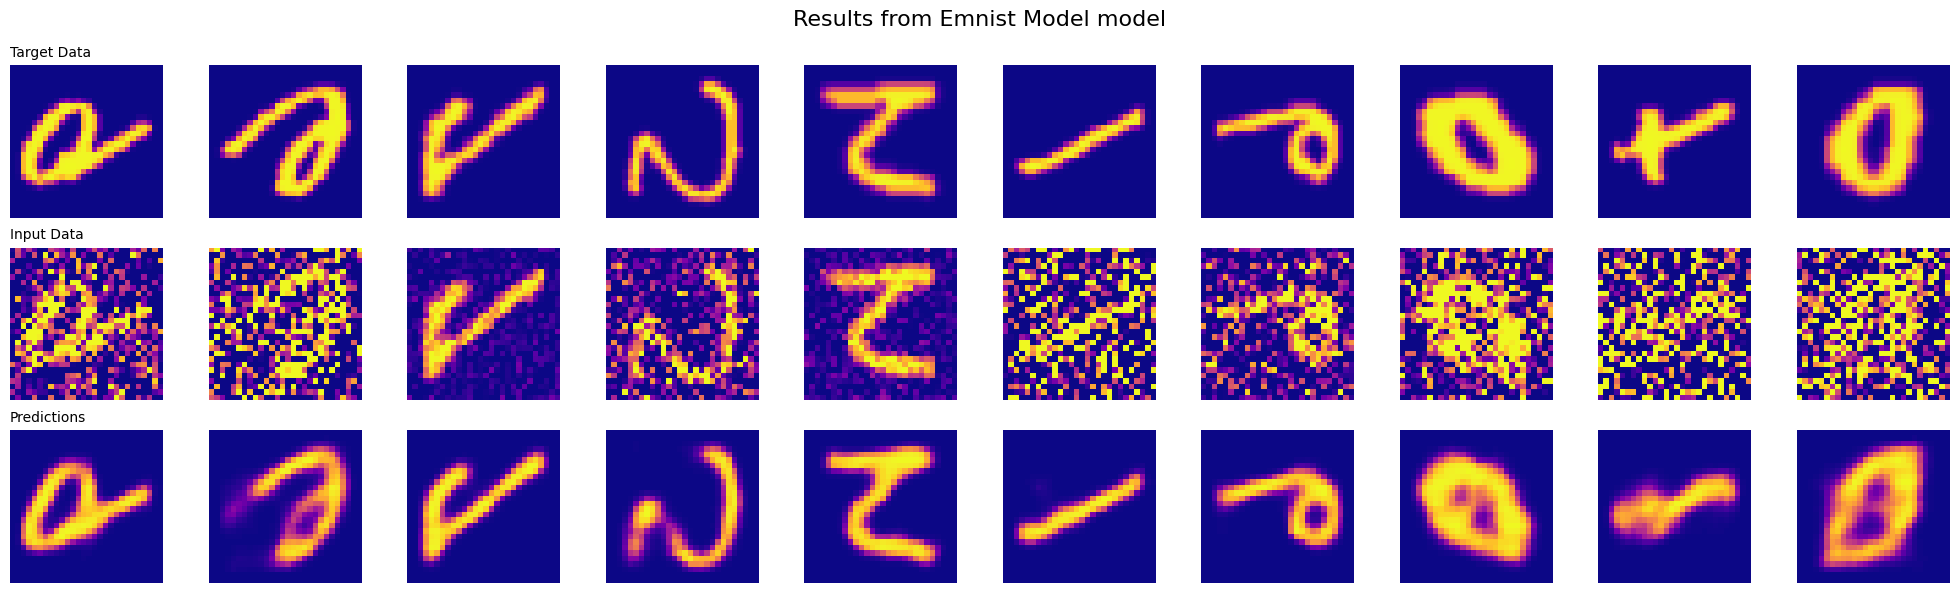

In [124]:
plot_preds(emnist_test,emnist_test_noise,emnist_test_pred,display_key,"Emnist Model")

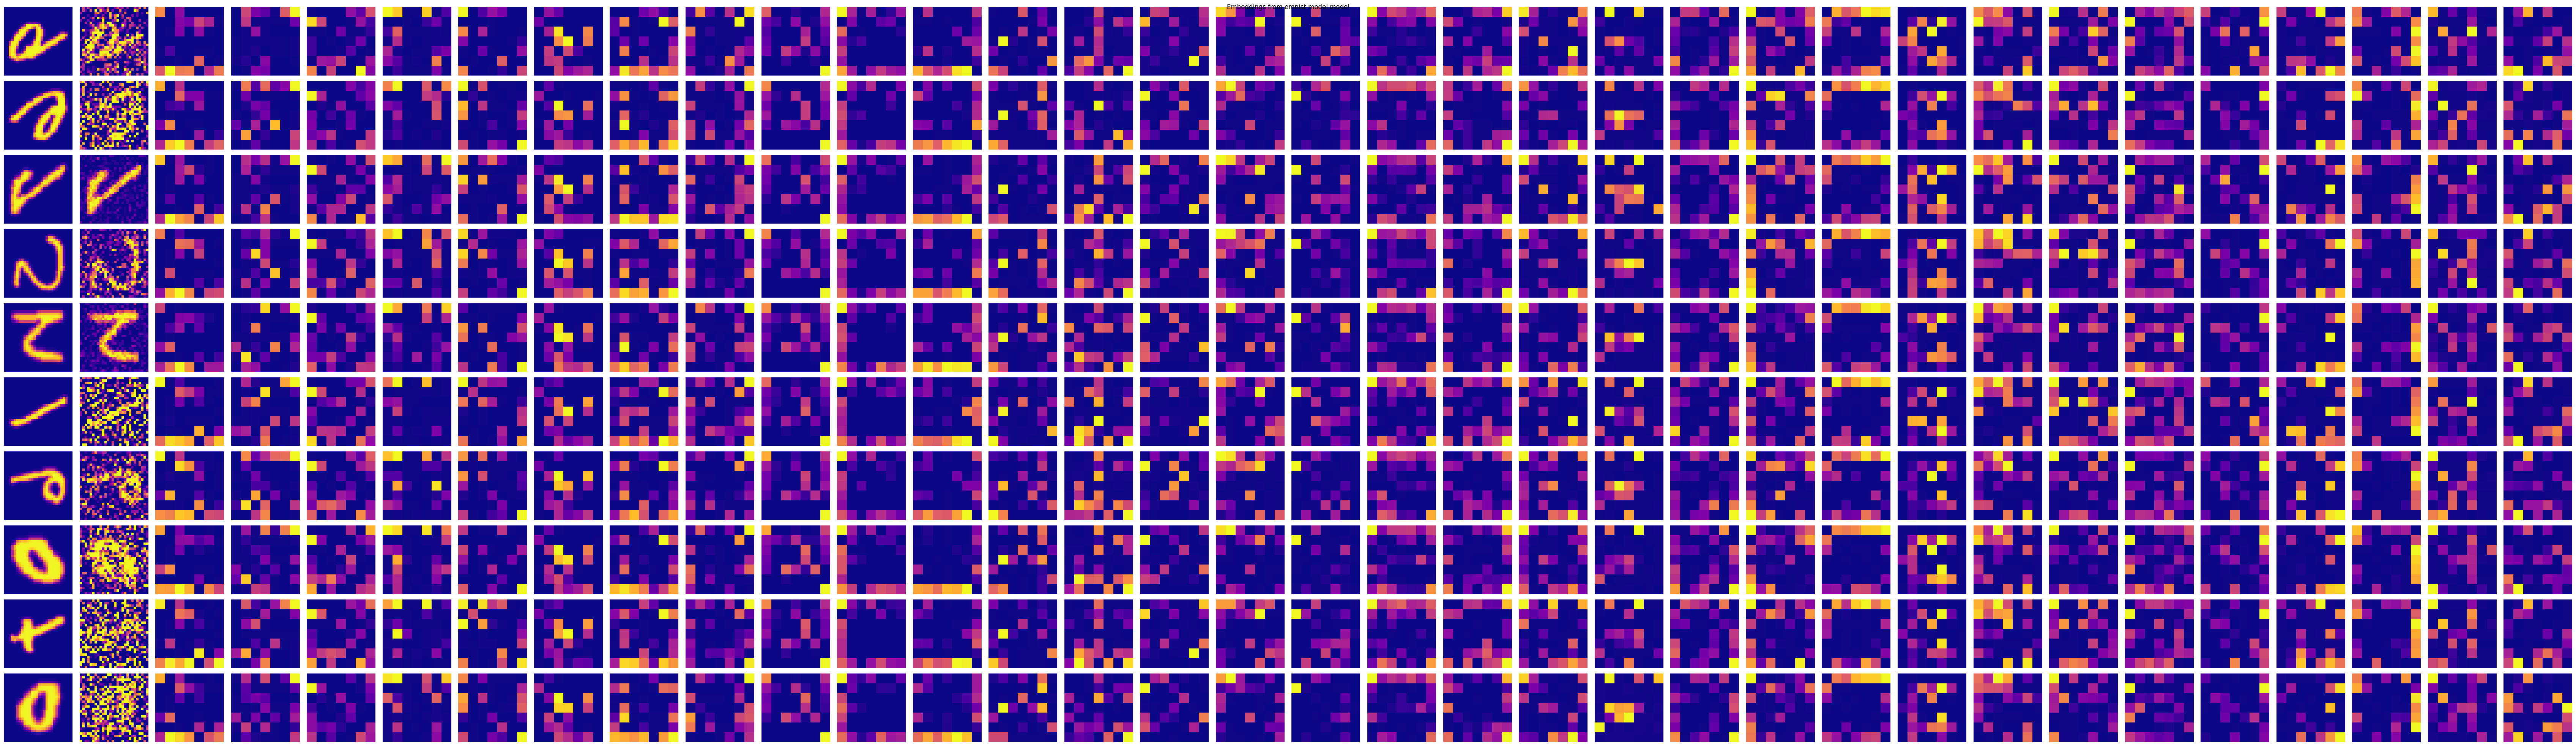

In [125]:
plot_embeddings(emnist_test,emnist_test_noise,emnist_test_embed,display_key, "emnist model")

In [111]:
def reshape(array):
    return array.reshape((len(array),-1))
data=jnp.load("/fred/oz440/jonah/data/mnist.npz")
labels=data['y_test']

In [112]:
pca3=PCA(n_components=3,random_state=42)
pca3_noise=pca3.fit_transform(reshape(mnist_test_noise))
pca3_embed=pca3.fit_transform(reshape(mnist_test_embed))
pca2=PCA(n_components=2,random_state=42)
pca2_noise=pca2.fit_transform(reshape(mnist_test_noise))
pca2_embed=pca2.fit_transform(reshape(mnist_test_embed))

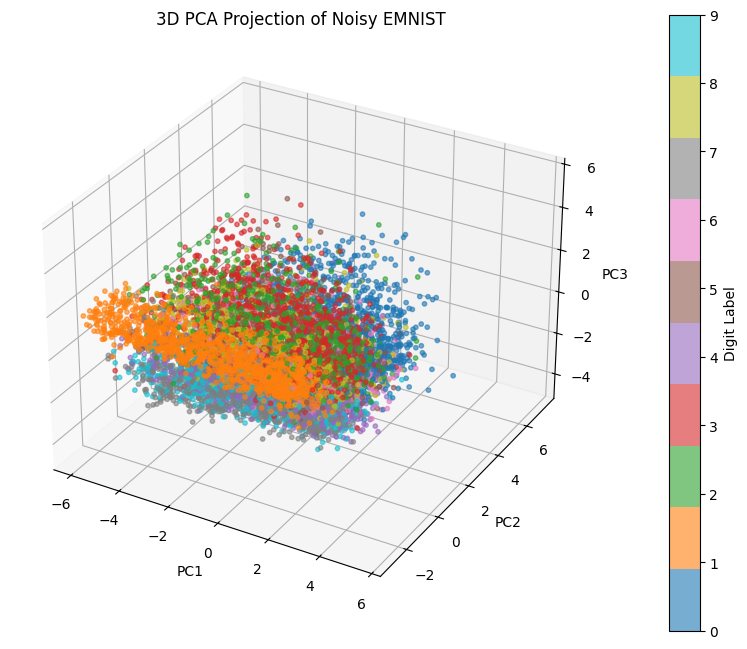

In [113]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(pca3_noise[:, 0], pca3_noise[:, 1], pca3_noise[:, 2],
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection of Noisy EMNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

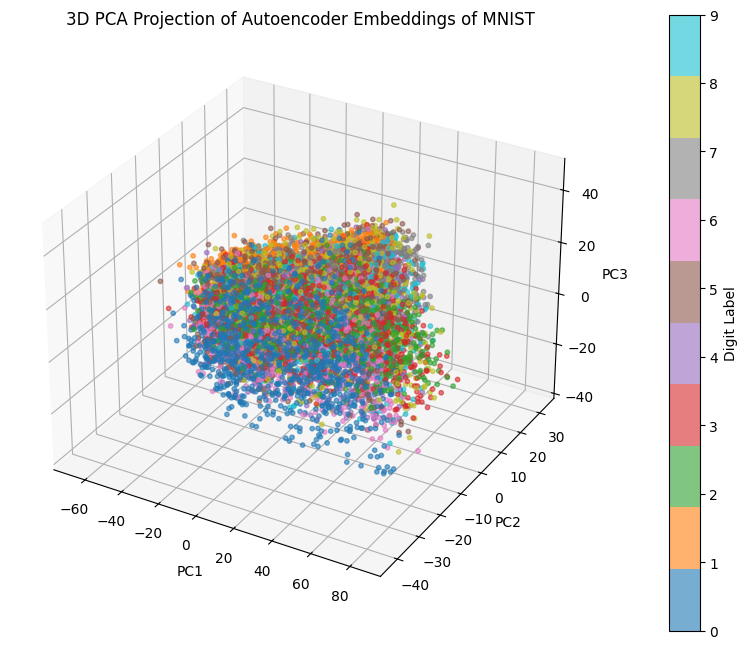

In [114]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(pca3_embed[:, 0], pca3_embed[:, 1], pca3_embed[:, 2],
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection of Autoencoder Embeddings of MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

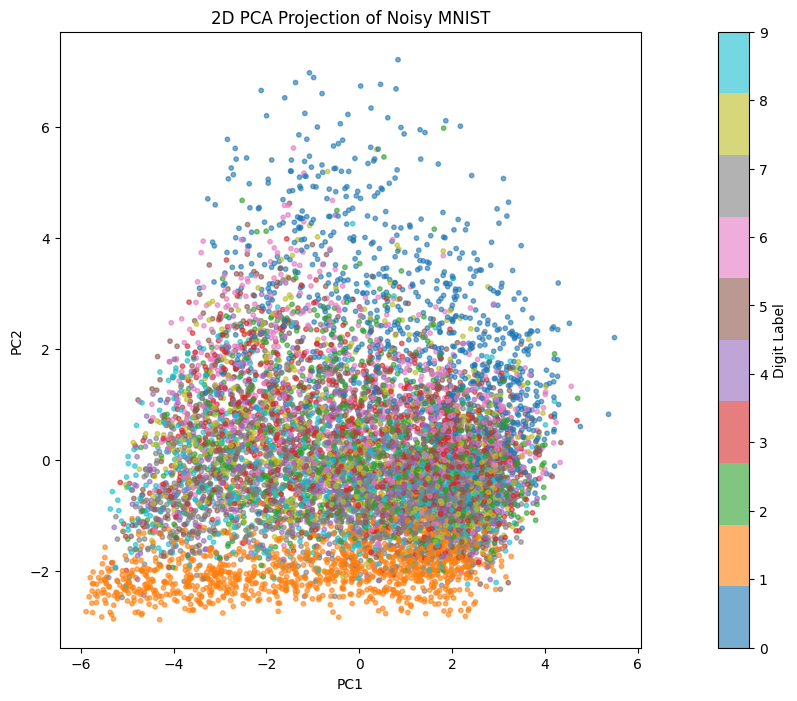

In [115]:
fig = plt.figure(figsize=(10, 8))
ax=fig.add_subplot()
scatter = ax.scatter(pca2_noise[:, 0], pca2_noise[:, 1], 
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("2D PCA Projection of Noisy MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

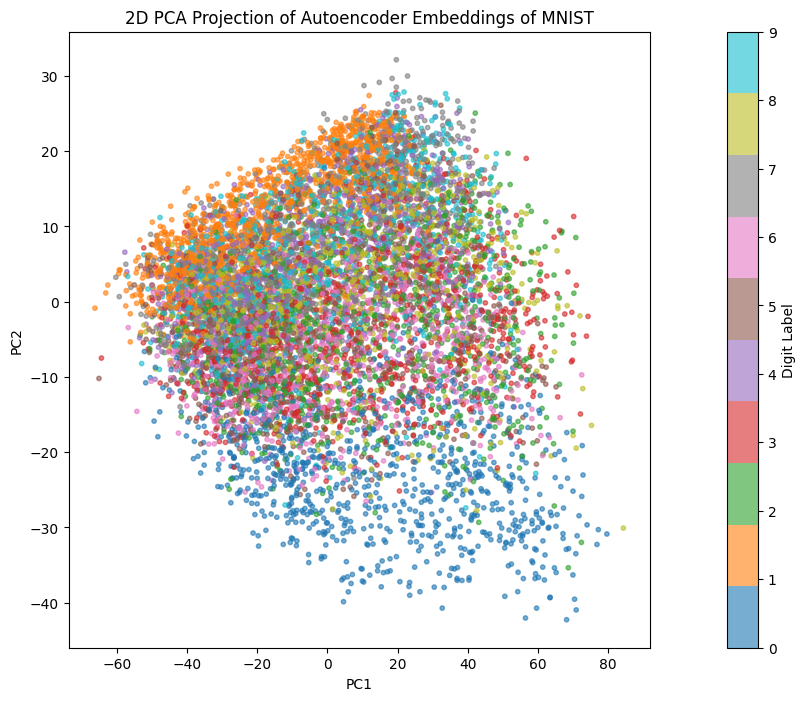

In [116]:
fig = plt.figure(figsize=(10, 8))
ax=fig.add_subplot()
scatter = ax.scatter(pca2_embed[:, 0], pca2_embed[:, 1], 
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("2D PCA Projection of Autoencoder Embeddings of MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

In [117]:
tsne3=TSNE(n_components=3,max_iter=500,n_iter_without_progress=150,n_jobs=2,random_state=42,verbose=True)
print("tsne3 noise")
tsne3_noise=tsne3.fit_transform(reshape(mnist_test_noise),labels)
print("tsne3 embed")
tsne3_embed=tsne3.fit_transform(reshape(mnist_test_embed),labels)

tsne3 noise
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 4.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.859986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.002083
[t-SNE] KL divergence after 500 iterations: 2.624279
tsne3 embed
[t

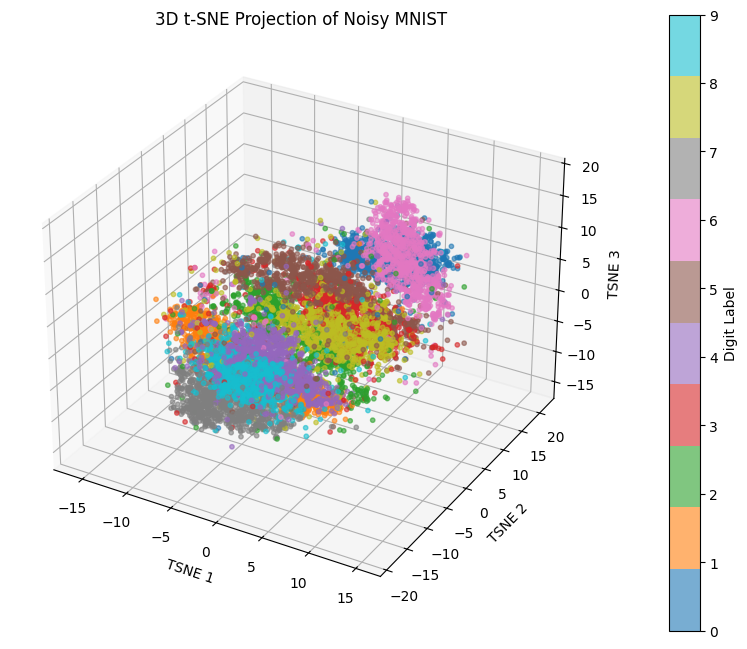

In [118]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(tsne3_noise[:, 0], tsne3_noise[:, 1], tsne3_noise[:, 2],
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_zlabel("TSNE 3")
ax.set_title("3D t-SNE Projection of Noisy MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

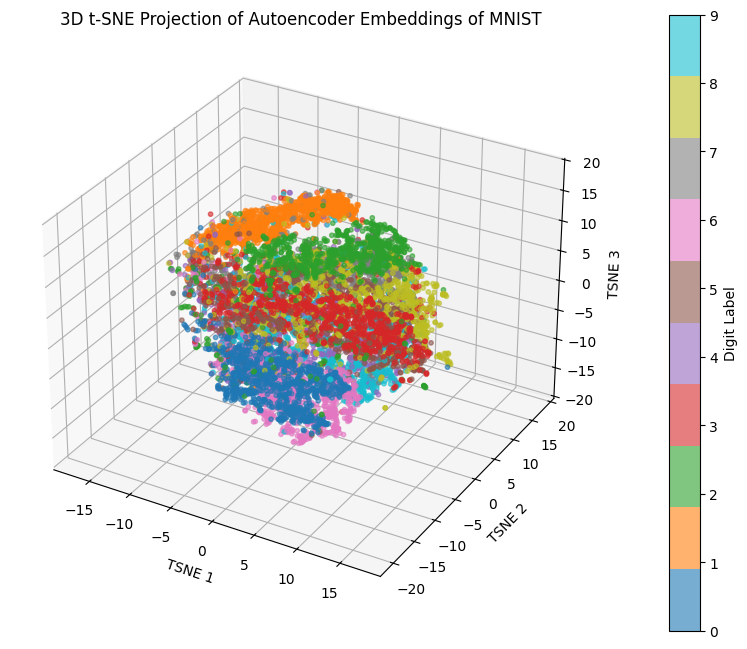

In [119]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(tsne3_embed[:, 0], tsne3_embed[:, 1], tsne3_embed[:, 2],
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_zlabel("TSNE 3")
ax.set_title("3D t-SNE Projection of Autoencoder Embeddings of MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

In [145]:
tsne2=TSNE(n_components=2,max_iter=750,n_iter_without_progress=250,n_jobs=2,random_state=42,verbose=True)
print("tsne2 noise")
tsne2_noise=tsne2.fit_transform(reshape(mnist_test_noise),labels)
print("tsne2 embed")
tsne2_embed=tsne2.fit_transform(reshape(mnist_test_embed),labels)

tsne2 noise
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 3.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.859986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.991501
[t-SNE] KL divergence after 750 iterations: 2.714820
tsne2 embed
[t

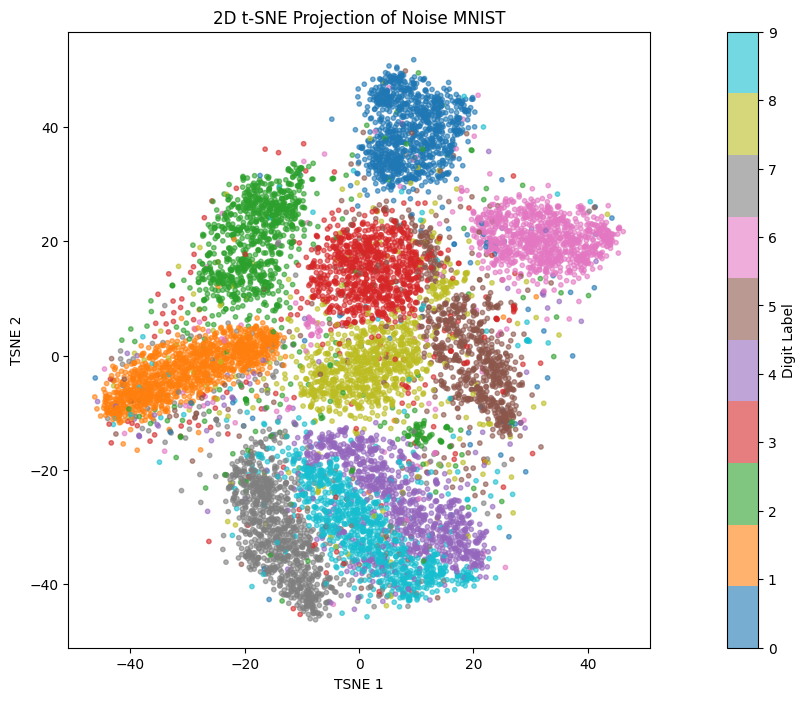

In [146]:
fig = plt.figure(figsize=(10, 8))
ax=fig.add_subplot()
scatter = ax.scatter(tsne2_noise[:, 0], tsne2_noise[:, 1], 
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_title("2D t-SNE Projection of Noise MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

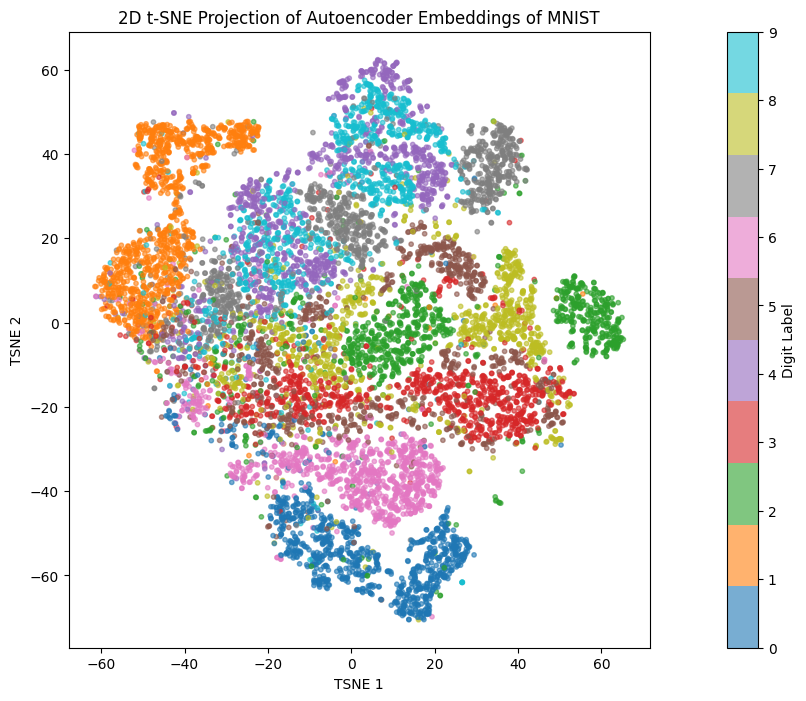

In [147]:
fig = plt.figure(figsize=(10, 8))
ax=fig.add_subplot()
scatter = ax.scatter(tsne2_embed[:, 0], tsne2_embed[:, 1], 
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_title("2D t-SNE Projection of Autoencoder Embeddings of MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

In [140]:
lle3=LLE(n_neighbors=30,n_components=3,method="standard")
lle2=LLE(n_neighbors=30,n_components=2,method="standard")
print("LLE3 noise")
lle3_noise=lle3.fit_transform(reshape(mnist_test_noise),labels)
print("lle3 embed")
lle3_embed=lle3.fit_transform(reshape(mnist_test_embed),labels)
print("lle2 noise")
lle2_noise=lle2.fit_transform(reshape(mnist_test_noise),labels)
lle2_embed=lle2.fit_transform(reshape(mnist_test_embed),labels)


LLE3 noise
lle3 embed
lle2 noise


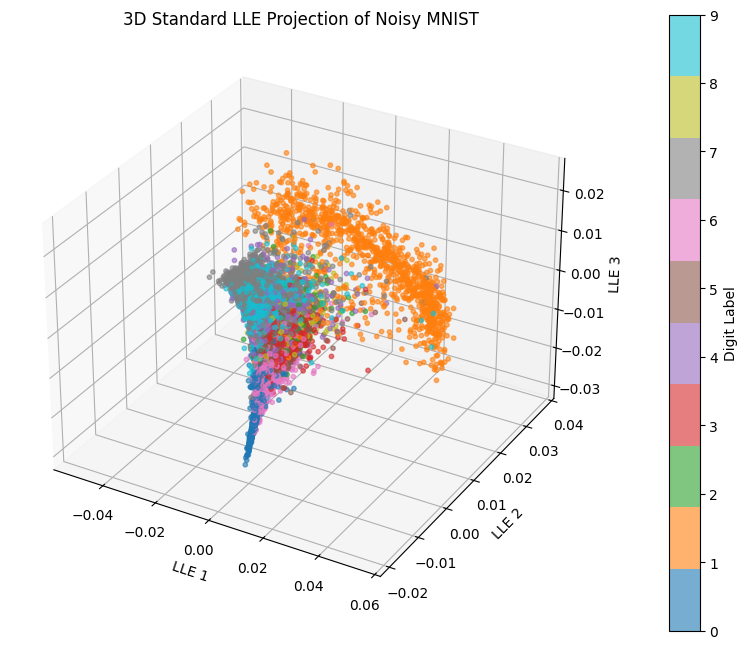

In [141]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(lle3_noise[:, 0], lle3_noise[:, 1], lle3_noise[:, 2],
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("LLE 1")
ax.set_ylabel("LLE 2")
ax.set_zlabel("LLE 3")
ax.set_title("3D Standard LLE Projection of Noisy MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

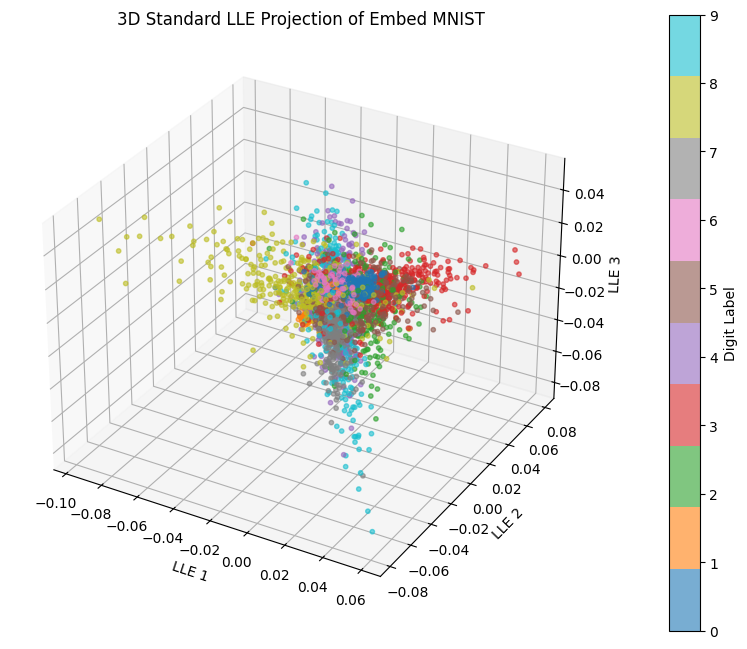

In [142]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(lle3_embed[:, 0], lle3_embed[:, 1], lle3_embed[:, 2],
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("LLE 1")
ax.set_ylabel("LLE 2")
ax.set_zlabel("LLE 3")
ax.set_title("3D Standard LLE Projection of Embed MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

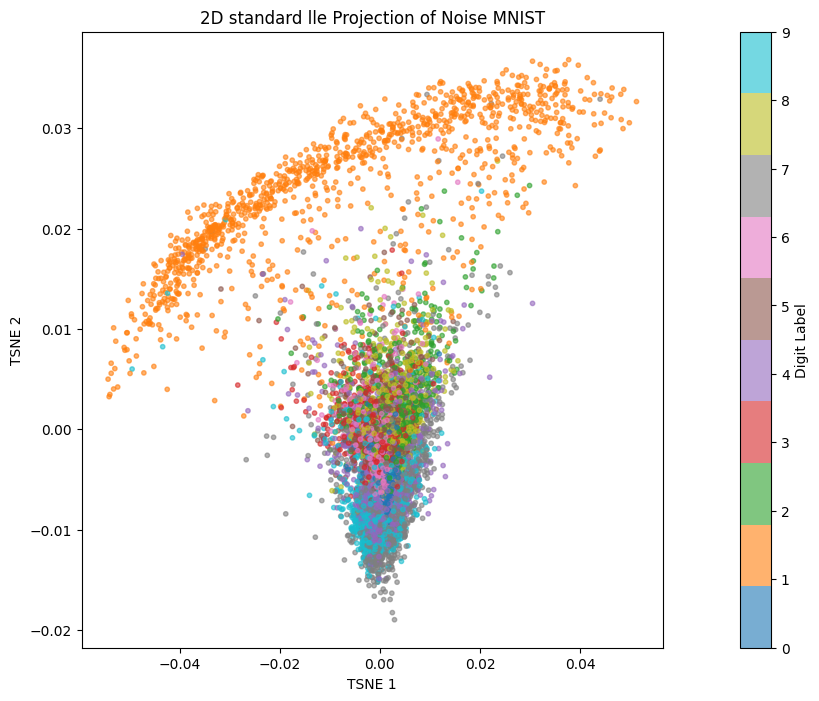

In [143]:
fig = plt.figure(figsize=(10, 8))
ax=fig.add_subplot()
scatter = ax.scatter(lle2_noise[:, 0], lle2_noise[:, 1], 
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_title("2D standard lle Projection of Noise MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()

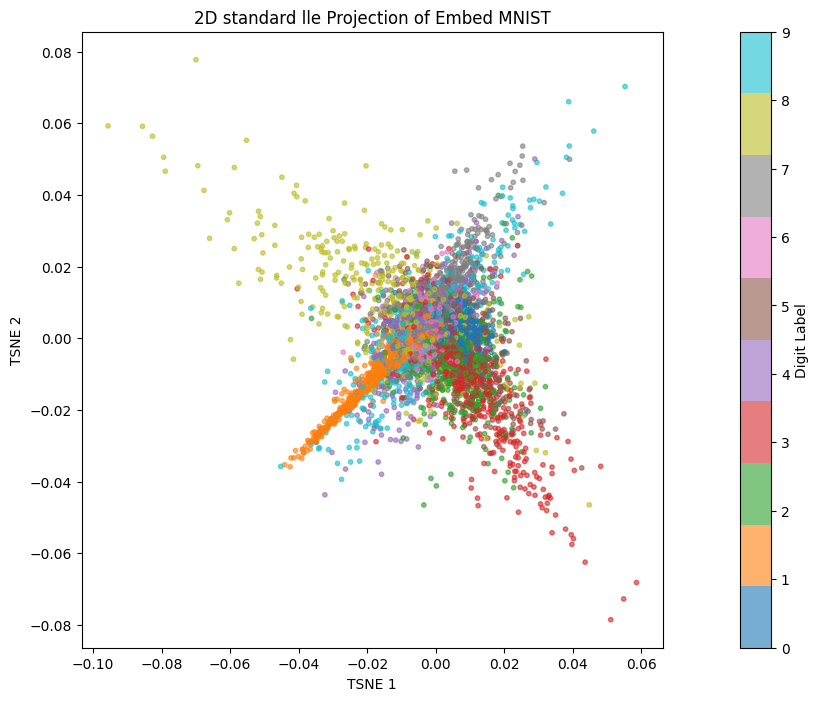

In [144]:
fig = plt.figure(figsize=(10, 8))
ax=fig.add_subplot()
scatter = ax.scatter(lle2_embed[:, 0], lle2_embed[:, 1], 
                     c=labels, cmap="tab10", s=10, alpha=0.6)
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_title("2D standard lle Projection of Embed MNIST")
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Digit Label")
plt.show()